In [13]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [14]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [15]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [16]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [17]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        inst.append(dataset_utilizer(**dictlis[i]))
        dfall.append(inst[i].dfall)
        df.append(inst[i].df)
        dfpred.append(inst[i].dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [18]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsE/suratom'] >= -2.0]

In [19]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

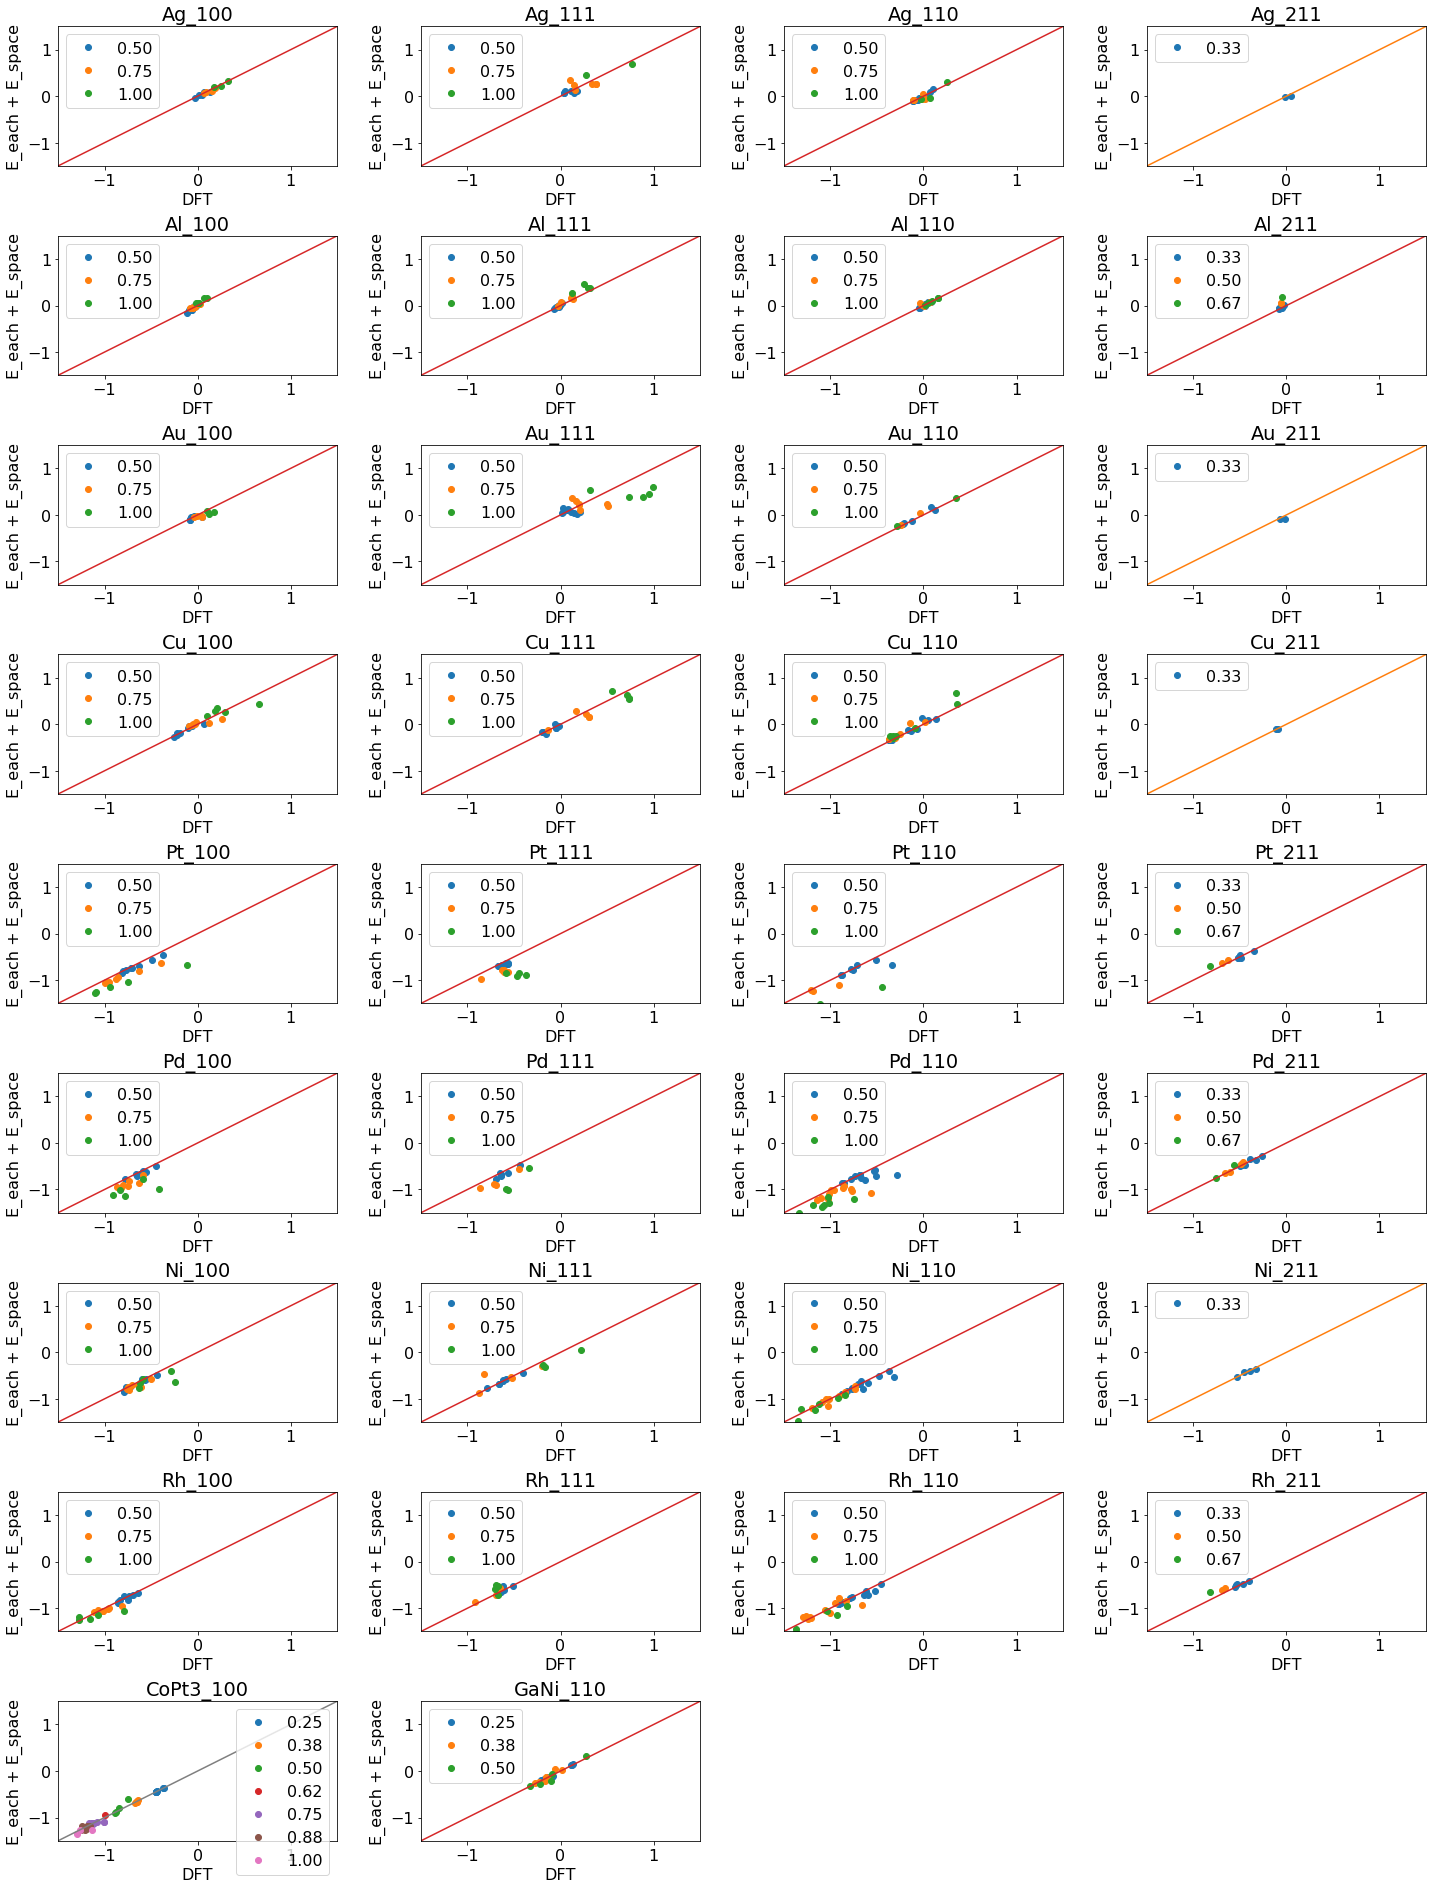

In [20]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
plt.savefig('E_residue.png', bbox_inches='tight')
# plt.show()

In [21]:
# dfall[14][dfall[14]['numberofads']==1]

In [22]:
# query('Cu_110_u2_RPBE_no004_CO_n1_d8.traj','local')

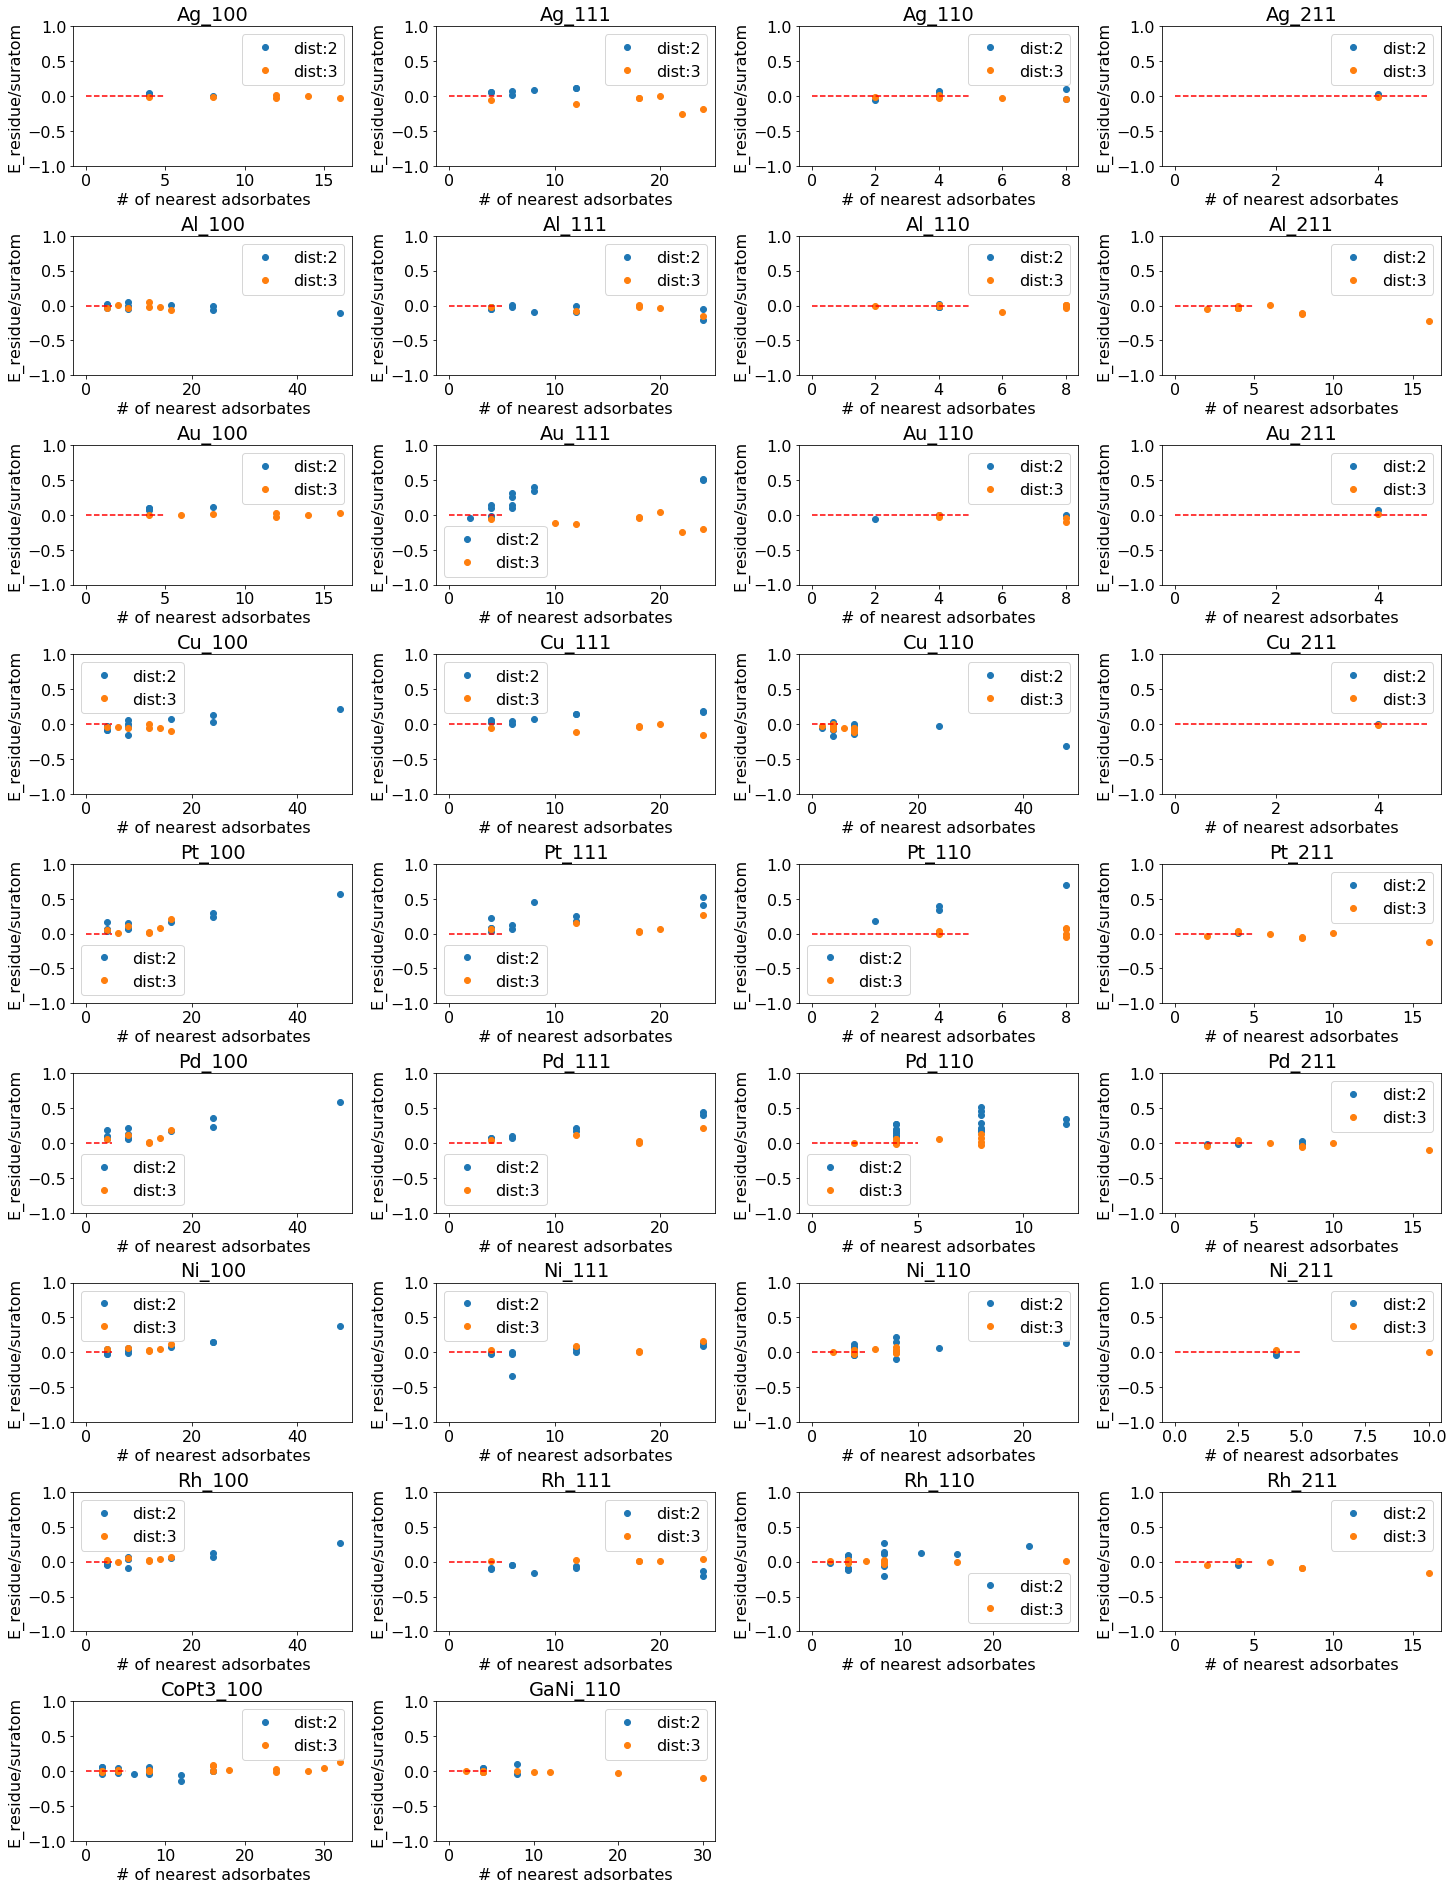

In [23]:
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
  #  plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

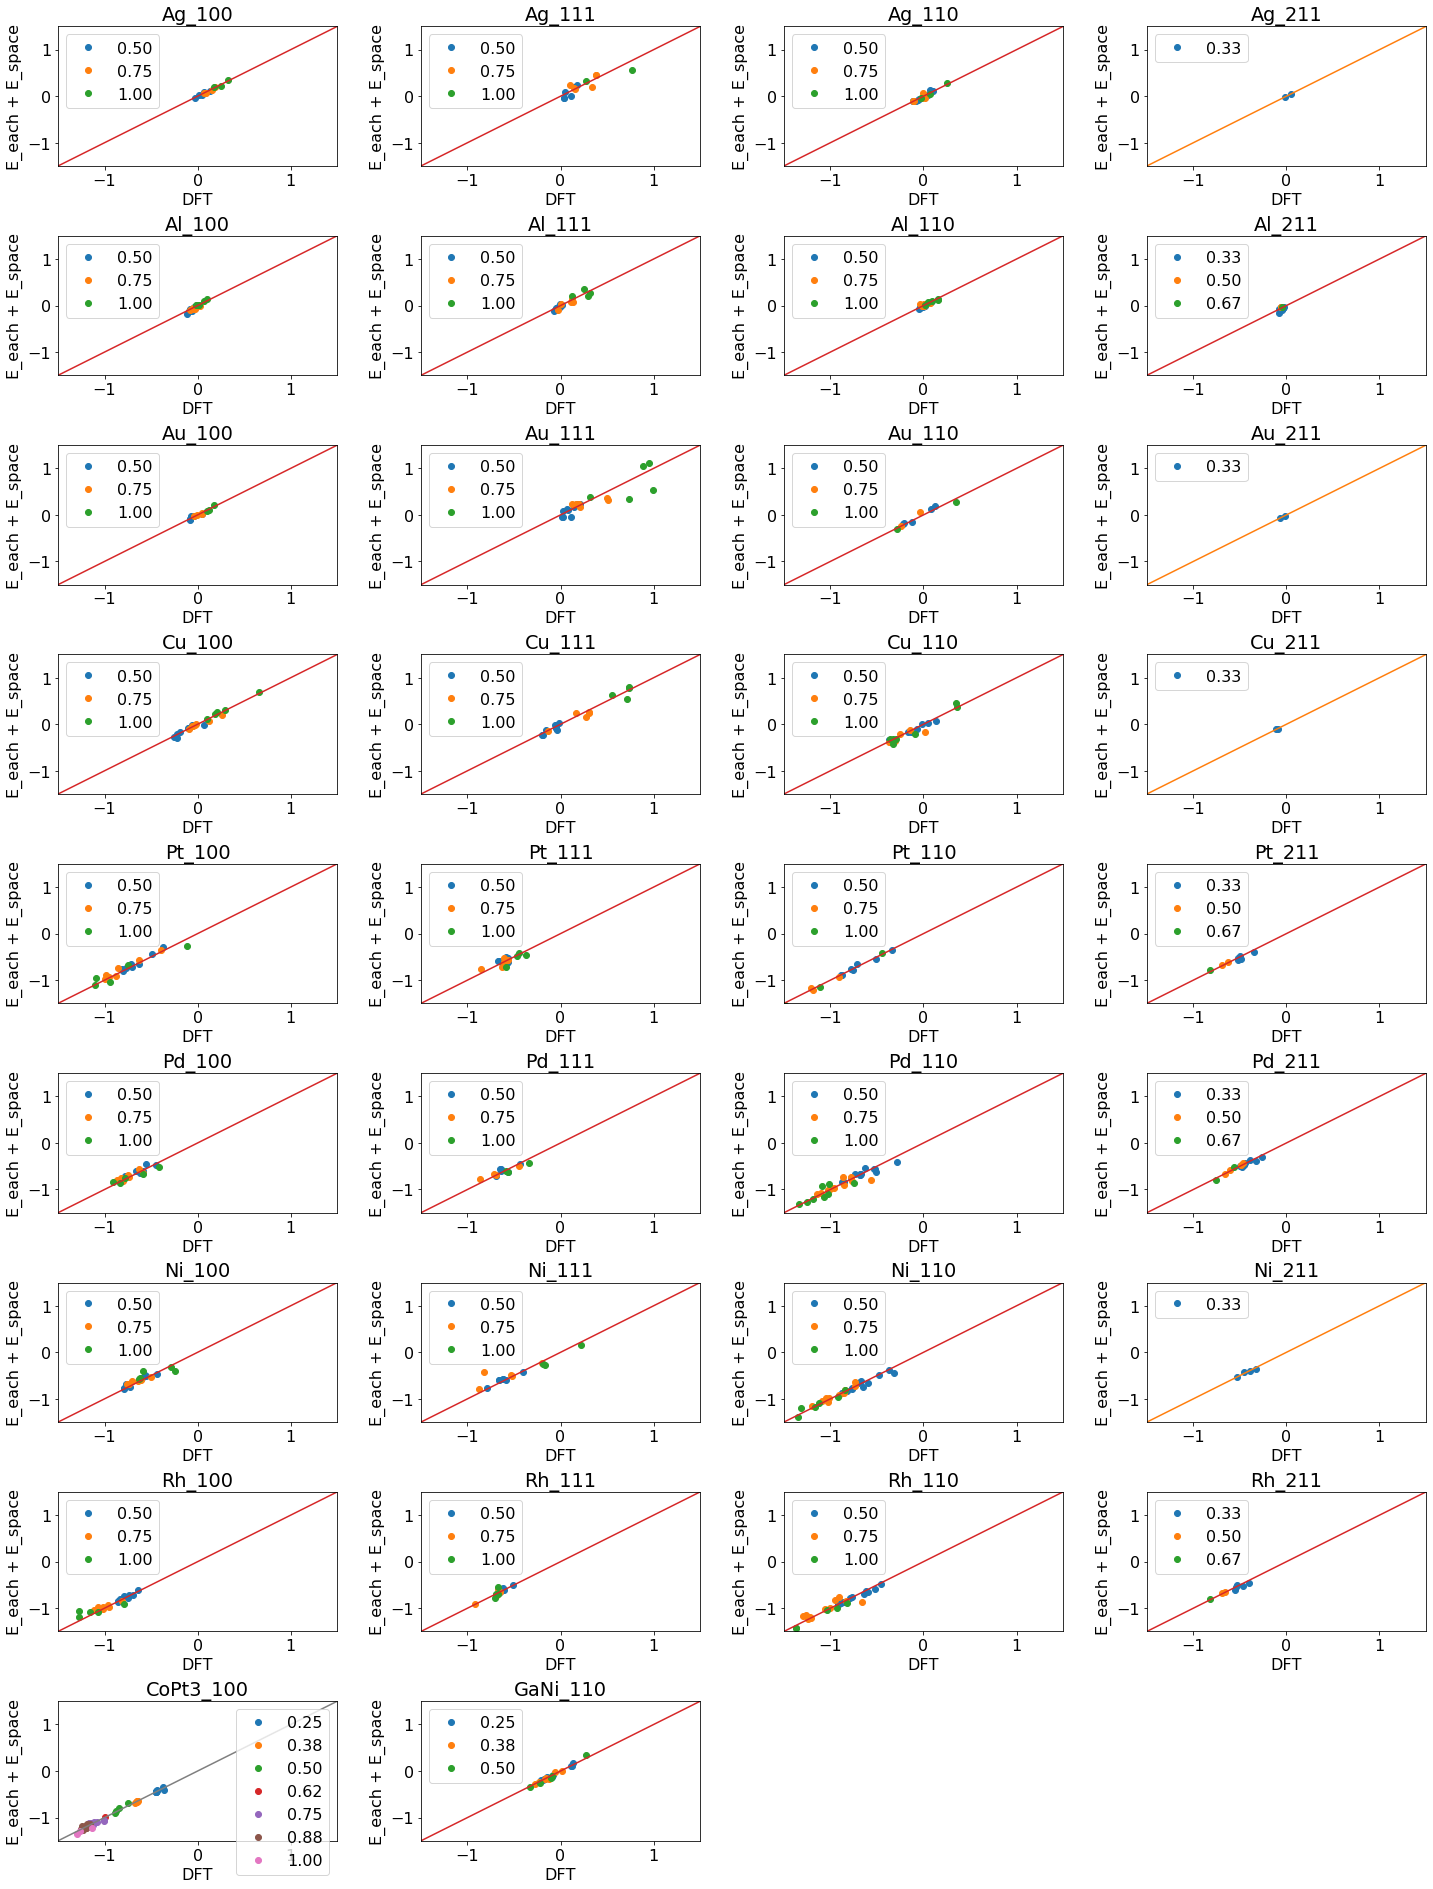

In [31]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        weight2, weight3 = inst[i].fit_weight_from_specific_element_and_face()
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
plt.savefig('E_pred_wmf_method1.png', bbox_inches='tight')
# plt.show()

In [32]:
# dfall[14]

In [33]:
# query('Cu_110_u2_RPBE_no003_CO_n1_d8_all.traj','local')

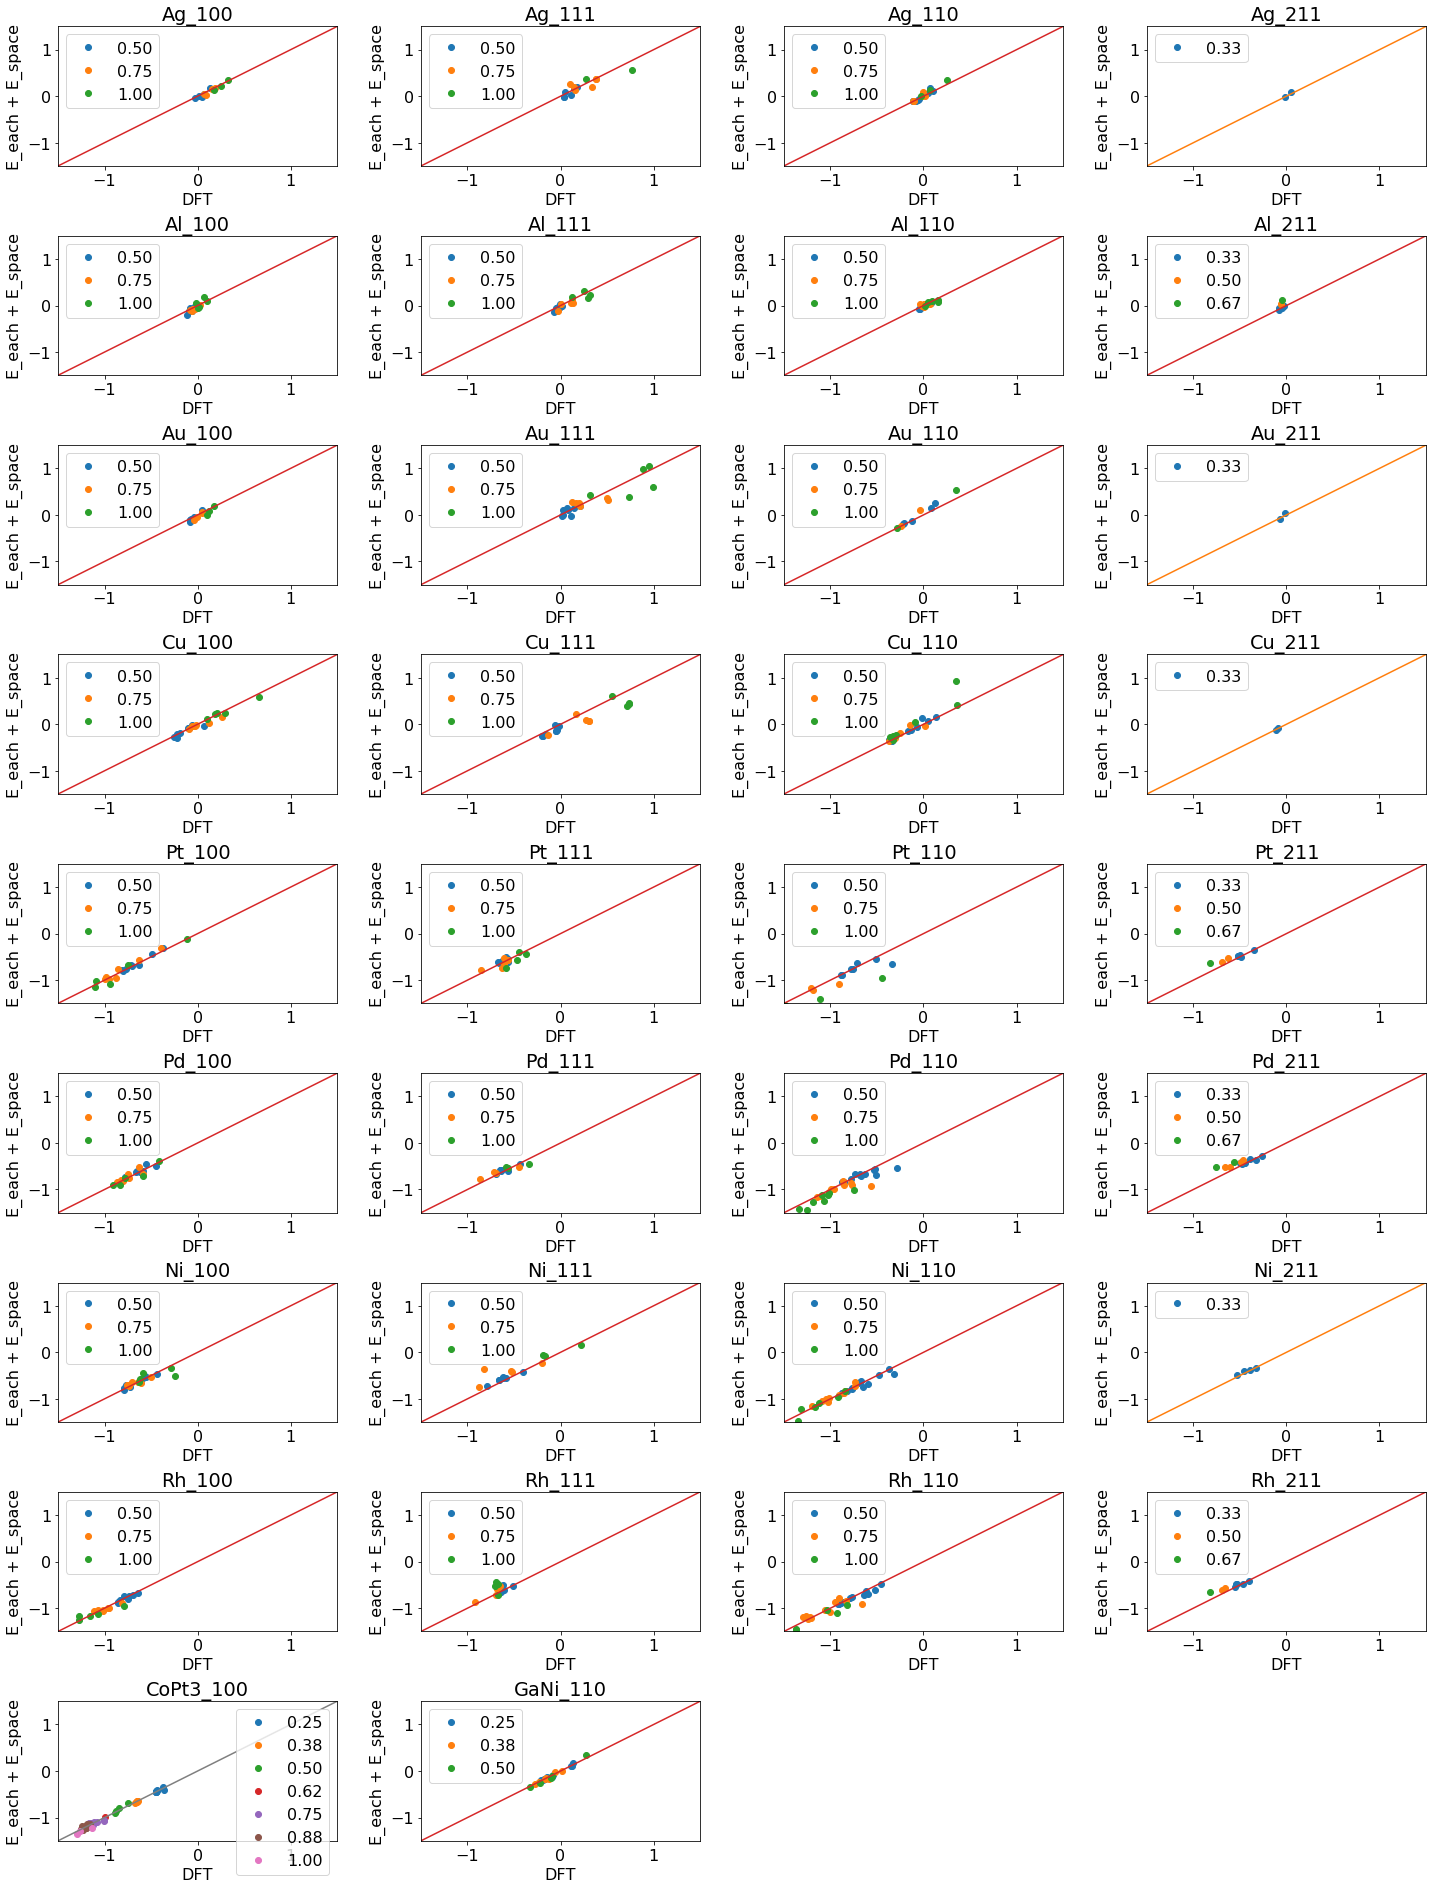

In [34]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        print
        weight2, weight3 = inst[i].fit_weight_from_specific_element()
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
plt.savefig('E_pred_wm_method1.png', bbox_inches='tight')
# plt.show()

In [28]:
# dfall[22]

In [29]:
# query('Pd_110_u2_RPBE_no002_CO_n1_d9.traj','local')

In [88]:
def get_adsorb_zdistance(atoms, adsorbate):
    '''
    Return maximum of minimum distance between each adsorbates and surface
    '''
    adseles = get_all_elements(adsorbate)
    baresurface, adsites = remove_adsorbate(atoms, adseles)
    mindists = []
    for pos in adsites:
        posdiff = pos - baresurface.positions
        minzdist = np.amin(posdiff, axis=0)[2]
        mindists.append(minzdist)
    maxdist = max(mindists)
    return maxdist

In [89]:
atoms = query('Pd_110_u2_RPBE_no028_CO_n4_d3.traj')
adsorbate = query('CO_RPBE.traj')

In [90]:
np.min(get_adsorb_zdistance(atoms, adsorbate))

1.1932615464275287